# <font color='blue'>Image Classification with Deep Learning and PyTorch</font>

In [1]:
# Python Language Version
from platform import python_version
print('Python Language Version Used in This Jupyter Notebook:', python_version())

Python Language Version Used in This Jupyter Notebook: 3.9.7


## Installing and Loading Libraries

In [ ]:
# Install PyTorch
#!pip install -q torch

In [ ]:
# Install Torchvision
#!pip install -q torchvision

In [ ]:
#conda install tensorflow

In [ ]:
#conda install -q torch

In [ ]:
#conda install -q torchvision

In [ ]:
#conda install numpy

In [ ]:
#conda install -c intel mkl

In [2]:
# Imports
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
import tensorflow
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Loading the Dataset

http://pytorch.org/docs/stable/torchvision/datasets.html

The training and test data were loaded, the training data was splited into a training and validation set, and then DataLoaders for each of these datasets were created.


Dataset used: https://www.cs.toronto.edu/~kriz/cifar.html

In [3]:
# Function that converts the data into a normalized tensor
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# Download training data
training_data = datasets.CIFAR10('data', 
                                train = True,
                                download = True, 
                                transform = transform)

Files already downloaded and verified


In [5]:
# Download test data
test_data = datasets.CIFAR10('data', 
                               train = False,
                               download = True, 
                               transform = transform)

Files already downloaded and verified


## Preparing Data Loaders

In [6]:
# Training data
training_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [7]:
# Test data
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [8]:
# Number of training samples
num_samples_training = len(training_data)
num_samples_training

50000

In [9]:
# An index was created and we made it random
index = list(range(num_samples_training))
np.random.shuffle(index)

In [10]:
# Percentage of the training data we will use in the validation dataset
valid_size = 0.2

In [11]:
# Now we do the split for the training and validation data
split = int(np.floor(valid_size * num_samples_training))
idx_training, idx_valid = index[split:], index[:split]

In [12]:
# We define the training samples
training_samples = SubsetRandomSampler(idx_training)

In [13]:
# We define the validation samples
samples_valid = SubsetRandomSampler(idx_valid)

Now we prepare the data loaders.

In [14]:
# Number of subprocesses to load the data
num_workers = 0

In [15]:
# Number of samples per batch
batch_size = 20

In [16]:
# Training Data Loader
loader_training = torch.utils.data.DataLoader(training_data, 
                                            batch_size = batch_size, 
                                            sampler = training_samples, 
                                            num_workers = num_workers)

In [17]:
# Validation Data Loader
loader_valid = torch.utils.data.DataLoader(training_data, 
                                           batch_size = batch_size, 
                                           sampler = samples_valid, 
                                           num_workers = num_workers)

In [18]:
# Test Data Loader
loader_test = torch.utils.data.DataLoader(test_data, 
                                           batch_size = batch_size, 
                                           num_workers = num_workers)

In [19]:
# List of image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Viewing the Data

In [20]:
# Function for denormalizing images
def imshow(img):
    
    # Undo normalization
    img = img / 2 + 0.5  
    
    # Convert to tensor and print it
    plt.imshow(np.transpose(img, (1, 2, 0))) 

In [21]:
# Get a batch of training data
dataiter = iter(loader_training)
images, labels = next(dataiter)

In [22]:
# Convert the images into NumPy format
images = images.numpy() 

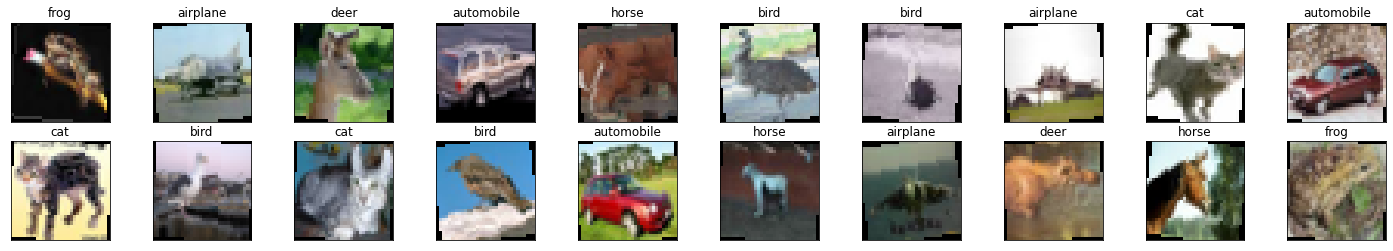

In [23]:
# Plot of a batch of training images

# Plot area
fig = plt.figure(figsize = (25, 4))

# Loop and print
for idx in np.arange(20):
    
    # Create the subplots
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    
    # Undo normalization
    # images[idx]
    imshow(images[idx])
    
    # Put the title
    ax.set_title(classes[labels[idx]])

## Viewing an Image in More Detail

Here we observe the normalized color channels of red, green and blue (RGB) as three separate images with grayscale intensity.

In [24]:
# We extract the color channels
rgb_img = np.squeeze(images[3])
channels = ['Red Channel', 'Green Channel', 'Blue Channel']

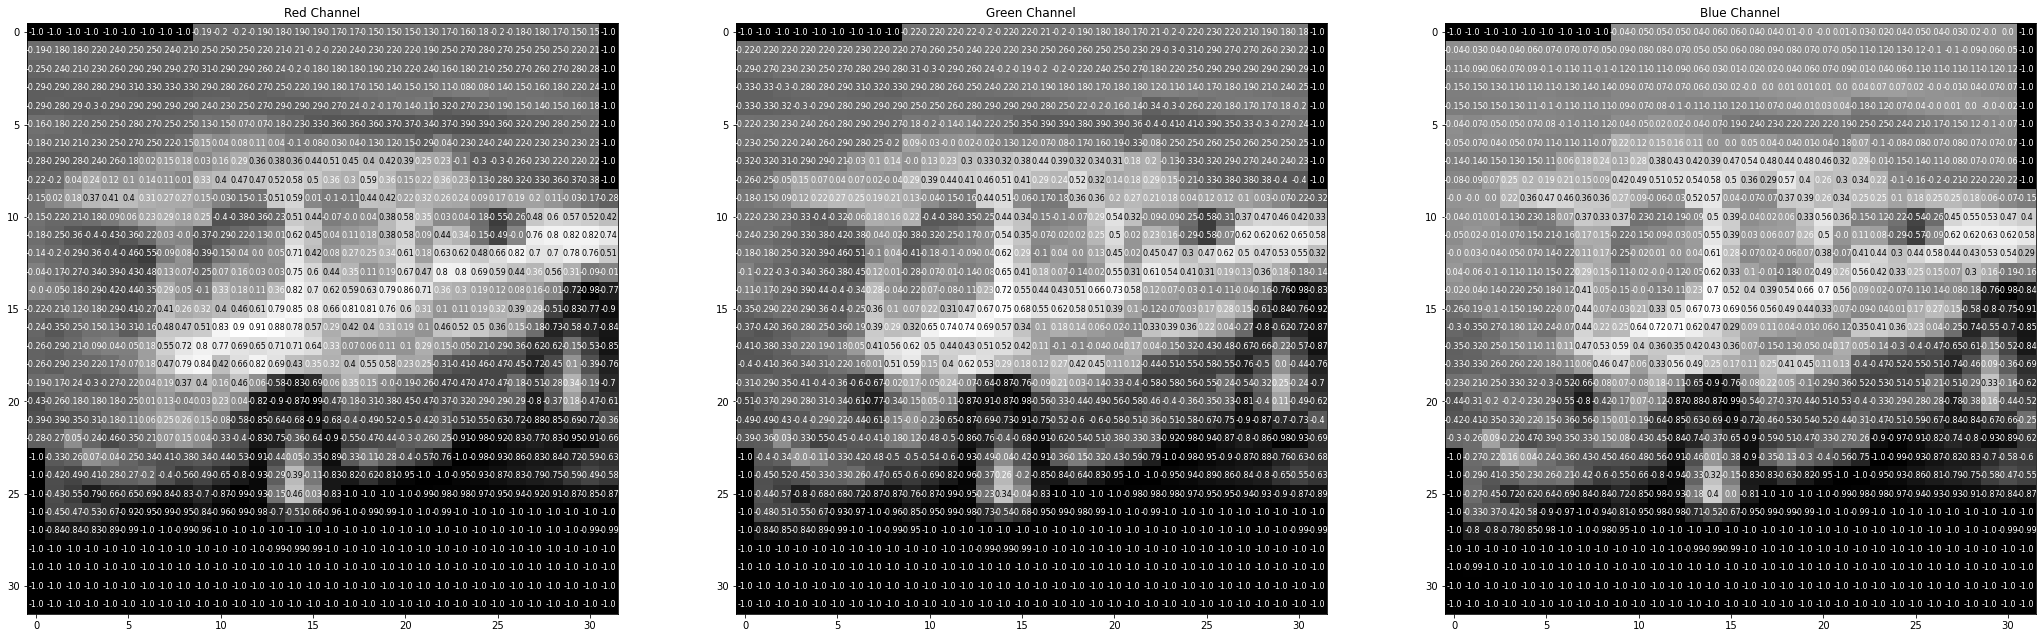

In [25]:
# Loop and print

# Plot area
fig = plt.figure(figsize = (36, 36)) 

# Loop through images
for idx in np.arange(rgb_img.shape[0]):
    
    # Subplot
    ax = fig.add_subplot(1, 3, idx + 1)
    
    # Index
    img = rgb_img[idx]
    
    # Shows the image in grayscale
    ax.imshow(img, cmap = 'gray')
    
    # Title
    ax.set_title(channels[idx])
    
    # Image width and height
    width, height = img.shape
    
    # Limit
    thresh = img.max()/2.5
    
    # Loop
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), 
                        xy = (y,x), 
                        horizontalalignment = 'center', 
                        verticalalignment = 'center', 
                        size = 8,
                        color = 'white' if img[x][y] < thresh else 'black')

## Defining the Network Architecture

http://pytorch.org/docs/stable/nn.html

Let's define a CNN (Convolutional Neural Network) architecture. 

* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), can be thought of as a stack of filtered images.

* [Maxpool layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.

* Linear + Dropout layers can avoid overfitting and produce a 10-dimensional output.

In [26]:
# Model Architecture
class CNNModel(nn.Module):
    
    # Constructor method
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Input Convolutional Layer 
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        
        # Hidden Convolutional Layer 
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        
        # Hidden Convolutional Layer 
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        
        # Max Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully Connected Layer 1
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        
        # Fully Connected Layer 2
        self.fc2 = nn.Linear(500, 10)
        
        # Dropout Layer (Regularization)
        self.dropout = nn.Dropout(0.5)

    # Forward method
    def forward(self, x):
        
        # Add a Relu Activation layer for each convolutional layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the convolution matrix and creates a vector
        x = x.view(-1, 64 * 4 * 4)
        
        # Add a dropout layer for regularization
        x = self.dropout(x)
        
        # Add the 1st hidden layer, with relu
        x = F.relu(self.fc1(x))
        
        # Add a dropout layer for regularization
        x = self.dropout(x)
        
        # Add 2nd hidden layer (classification made by the model)
        x = self.fc2(x)
        return x

In [27]:
# Create a model
model = CNNModel()
print(model)

CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Loss Function

http://pytorch.org/docs/stable/nn.html#loss-functions

In [28]:
# Loss function as categorical cross-entropy
criterion = nn.CrossEntropyLoss()

## Optimizer

http://pytorch.org/docs/stable/optim.html

In [29]:
# Hyperparameter
learning_rate = 0.01

In [30]:
# Optimizer with SGD
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

## Training

If the validation loss increases with time, this indicates a possible overfitting.

In [31]:
# Number of epochs to train the model
num_epochs = 30

In [32]:
# hyperparameter for controlling the error change in validation
error_valid_min = np.Inf 

We train the model:

In [33]:
%%time
for epoch in range(1, num_epochs + 1):

    # Parameters for tracking total error in training and validation
    training_error = 0.0
    error_valid = 0.0
    
    # Starts training the model
    model.train()
    
    # Loop through batches of training data
    for batch_idx, (data, target) in enumerate(loader_training):
        
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # Forward: calculate the expected outputs
        output = model(data)
        
        # Calculate the error in the batch
        loss = criterion(output, target)
        
        # Backward: calculate the gradient of the loss with respect to the model parameters
        loss.backward()
        
        # Performs a single optimization step (updating the parameters)
        optimizer.step()
        
        # Updates the total error in training
        training_error += loss.item() * data.size(0)
        
    # Starts model validation
    model.eval()
    
    # Loop through validation data batches
    for batch_idx, (data, target) in enumerate(loader_valid):
        
        # Forward: calculate the expected outputs
        output = model(data)
        
        # Calculate the error in the batch
        loss = criterion(output, target)
        
        # Update the total validation error
        error_valid += loss.item() * data.size(0)
    
    # Calculate the mean error
    training_error = training_error / len(loader_training.dataset)
    error_valid = error_valid / len(loader_valid.dataset)
        
    # Print
    print('\nEpoch: {} \tError in Training: {:.6f} \tError in Validation: {:.6f}'.format(epoch, 
                                                                                         training_error, 
                                                                                         error_valid))
    
    # Save the model whenever the loss in validation decreases
    if error_valid <= error_valid_min:
        print('Error in Validation was Reduced ({:.6f} --> {:.6f}). Saving the Model...'.format(error_valid_min,
                                                                                                 error_valid))
        #torch.save(modelo.state_dict(), 'C:/Gustavo/Image_classification_deep_learning_Pytorch/models/final_model.pt')
        torch.save(model.state_dict(), 'C:/Gustavo/Image_classification_deep_learning_Pytorch/models/final_model.pt')
        
        error_valid_min = error_valid


Epoch: 1 	Error in Training: 1.693180 	Error in Validation: 0.384773
Error in Validation was Reduced (inf --> 0.384773). Saving the Model...

Epoch: 2 	Error in Training: 1.443898 	Error in Validation: 0.320468
Error in Validation was Reduced (0.384773 --> 0.320468). Saving the Model...

Epoch: 3 	Error in Training: 1.280203 	Error in Validation: 0.293853
Error in Validation was Reduced (0.320468 --> 0.293853). Saving the Model...

Epoch: 4 	Error in Training: 1.198272 	Error in Validation: 0.278744
Error in Validation was Reduced (0.293853 --> 0.278744). Saving the Model...

Epoch: 5 	Error in Training: 1.145338 	Error in Validation: 0.262510
Error in Validation was Reduced (0.278744 --> 0.262510). Saving the Model...

Epoch: 6 	Error in Training: 1.097832 	Error in Validation: 0.255478
Error in Validation was Reduced (0.262510 --> 0.255478). Saving the Model...

Epoch: 7 	Error in Training: 1.056343 	Error in Validation: 0.255636

Epoch: 8 	Error in Training: 1.017645 	Error in Vali

### Load the Final Model

In [34]:
# Load the model
model.load_state_dict(torch.load('C:/Gustavo/Image_classification_deep_learning_Pytorch/models/final_model.pt'))

<All keys matched successfully>

## Testing and Evaluating the Final Model

The trained model was trained on data never seen before! A "good" result will be a CNN that gets about 70% (or more) accuracy on the test images.

In [35]:
# Error in test
test_error = 0.0

In [36]:
# Model hit control
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [37]:
# Starts template evaluation
model.eval()

# Loop through test data batches
for batch_idx, (data, target) in enumerate(loader_test):
  
    # Forward
    output = model(data)
    
    # Calculate the error
    loss = criterion(output, target)
    
    # Update the error under test
    test_error += loss.item() * data.size(0)
    
    # Convert output probabilities to expected class
    _, pred = torch.max(output, 1)    
    
    # Compare the predictions with the actual label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) #if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # Calculates the accuracy of the test for each class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Mean error under test
test_error = test_error / len(loader_test.dataset)
print('\nError in Test: {:.6f}\n'.format(test_error))

# Calculate the accuracy for each class
for i in range(10):
    if class_total[i] > 0:
        print('Accuracy in Class Testing %5s: %2d%% (%2d/%2d)' % (classes[i], 
                                                             100 * class_correct[i] / class_total[i],
                                                             np.sum(class_correct[i]), 
                                                             np.sum(class_total[i])))
    else:
        print('Accuracy in Testing of %5s:)' % (classes[i]))

# Calculate total accuracy
print('\nTest Accuracy (Total): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                        np.sum(class_correct), 
                                                        np.sum(class_total)))


Error in Test: 0.790840

Accuracy in Class Testing airplane: 75% (755/1000)
Accuracy in Class Testing automobile: 84% (845/1000)
Accuracy in Class Testing  bird: 61% (618/1000)
Accuracy in Class Testing   cat: 51% (518/1000)
Accuracy in Class Testing  deer: 64% (642/1000)
Accuracy in Class Testing   dog: 62% (623/1000)
Accuracy in Class Testing  frog: 86% (862/1000)
Accuracy in Class Testing horse: 77% (775/1000)
Accuracy in Class Testing  ship: 85% (858/1000)
Accuracy in Class Testing truck: 82% (824/1000)

Test Accuracy (Total): 73% (7320/10000)


## Predictions with the Trained Model

In [38]:
# Get a batch of test data
dataiter = iter(loader_test)
#images, labels = dataiter.next()
images, labels = next(dataiter)
images.numpy()

array([[[[-1.        , -1.        , -1.        , ..., -0.01960784,
          -0.06666666, -1.        ],
         [ 0.24705887,  0.2941177 ,  0.30196083, ...,  0.0196079 ,
          -0.05882353, -1.        ],
         [ 0.18431377,  0.24705887,  0.30196083, ...,  0.06666672,
          -0.00392157, -1.        ],
         ...,
         [-1.        , -0.60784316, -0.7254902 , ..., -0.5294118 ,
          -0.79607844, -0.77254903],
         [-1.        , -0.46666664, -0.67058825, ..., -0.62352943,
          -0.8117647 , -0.73333335],
         [-1.        , -0.52156866, -0.6156863 , ..., -1.        ,
          -1.        , -1.        ]],

        [[-1.        , -1.        , -1.        , ..., -0.2862745 ,
          -0.3098039 , -1.        ],
         [-0.12941176, -0.09019607, -0.0745098 , ..., -0.25490195,
          -0.30196077, -1.        ],
         [-0.1372549 , -0.10588235, -0.09019607, ..., -0.2235294 ,
          -0.26274508, -1.        ],
         ...,
         [-1.        , -0.15294117

In [39]:
# Predicts with the trained model
output = model(images)

In [40]:
# Converts output probabilities to expected class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())# if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


In parentheses the actual class. Red indicates model error.



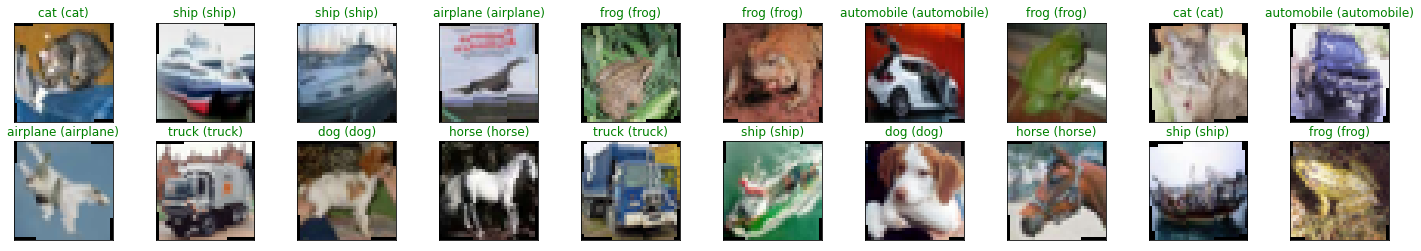

In [41]:
# Plot of the forecasts
fig = plt.figure(figsize = (25, 4))
print("\nIn parentheses the actual class. Red indicates model error.\n")
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), 
                 color = ("green" if preds[idx] == labels[idx].item() else "red"))

# End